In [1]:
import json
from utilis.helper import extract_json
import numpy as np

import matplotlib.pyplot as plt

   
# Load coefficients from JSON file
coefficient_data = extract_json('model_coefficients.json')

# extract coefficients
velocity_data = coefficient_data["diff_velocity_mps2"]
hr_data = coefficient_data["diff_heartrate_bps2"]

# initialize variables here
initial_pace = 0
initial_heartrate = 1
max_pace = 5  # maximum pace in m/s
max_heartrate = 3  # maximum heartrate in beats per second
resting_heartrate = 1

# for now we keep all of external factors constant
initial_altitude = 100
initial_grade_percent = 0
initial_headwind = 1
initial_crosswind = 0
initial_temp = 1.0
initial_humidity = 2.0
initial_dew_point = 2.0
initial_uvindex = 1.0

# storage for all information
data = {
    'time_s': [],
    'distance_m': [],
    'heartrate_bps': [],
    'pace_mps': [],
    'pace_efficiency': [],
    'diff_pace_efficiency': [],
    'altitude_m': [],
    'diff_altitude_mps': [],
    'headwind_mps': [],
    'crosswind_mps': [],
    'grade_percent': [],
    'cumulative_elevation_gain_m': []
}

# initialize the data by plugging in these initializations
data['time_s'].append(0)
data['distance_m'].append(0)
data["heartrate_bps"].append(initial_heartrate)
data["pace_mps"].append(initial_pace)
data["pace_efficiency"].append(1.0)  # assuming initial efficiency is 1.0
data["diff_pace_efficiency"].append(0.0)
data["altitude_m"].append(initial_altitude)
data["diff_altitude_mps"].append(0.0)
data["headwind_mps"].append(initial_headwind)
data["crosswind_mps"].append(initial_crosswind)
data["grade_percent"].append(initial_grade_percent)
data["cumulative_elevation_gain_m"].append(0.0)

# specify how long we run and until what distance
run_duration = 50  # in seconds
target_distance = 100  # in meters

print(f"Starting simulation with maximum run duration of {run_duration} seconds and target distance of {target_distance} meters")

# create a matrix that stores the coefficients for each factor
coefficients_matrix = np.array([list(velocity_data['features'].values()), list(hr_data['features'].values())])

# add the bias term
bias = np.array([[velocity_data["bias"]], [hr_data["bias"]]])
coefficients_matrix = np.hstack((coefficients_matrix, bias))
# print(list(velocity_data['features'].values()))
# print(coefficients_matrix)

while ((data['time_s'][-1] < run_duration) and (data['distance_m'][-1] < target_distance)):
    # put these into a vector first
    if data['time_s'][-1] < 5:
        heartrate_lag_5 = data['heartrate_bps'][0]
        pace_lag_5 = data['pace_mps'][0]
    else:
        heartrate_lag_5 = data['heartrate_bps'][-5]
        pace_lag_5 = data['pace_mps'][-5]

    if data['time_s'][-1] < 20:
        heartrate_lag_20 = data['heartrate_bps'][0]
        pace_lag_20 = data['pace_mps'][0]
    else:
        heartrate_lag_20 = data['heartrate_bps'][-20]
        pace_lag_20 = data['pace_mps'][-20]

    # most recent values
    distance = data['distance_m'][-1]
    heartrate = data['heartrate_bps'][-1]
    pace = data['pace_mps'][-1]
    pace_efficiency = data["pace_efficiency"][-1]
    diff_pace_efficiency = data["pace_efficiency"][-1]
    altitude = data['altitude_m'][-1]
    diff_altitude = data['diff_altitude_mps'][-1]
    headwind = data['headwind_mps'][-1]
    crosswind = data['crosswind_mps'][-1]
    grade_percent = data['grade_percent'][-1]
    cumulative_elevation_gain = data['cumulative_elevation_gain_m'][-1]

    x = np.array([[distance, 
                heartrate, 
                heartrate_lag_5, 
                heartrate_lag_20, 
                pace, 
                pace_lag_5, 
                pace_lag_20,
                pace_efficiency,
                diff_pace_efficiency,
                altitude,
                diff_altitude,
                headwind,
                crosswind,
                grade_percent,
                cumulative_elevation_gain,
                initial_temp,
                initial_humidity,
                initial_dew_point,
                initial_uvindex,
                1
                ]]).T

    # perform matrix multiplication
    x_dot = coefficients_matrix @ x

    # get the new heartrate
    pace_dot = x_dot[0, 0]
    heartrate_dot = x_dot[1, 0]

    # get the new pace and heartrate
    data['time_s'].append(data['time_s'][-1] + 1)  # Increment time by 1 second
    data['heartrate_bps'].append(float(data['heartrate_bps'][-1] + heartrate_dot))
    data['pace_mps'].append(float(data['pace_mps'][-1] + pace_dot))
    data['distance_m'].append(data['distance_m'][-1] + data['pace_mps'][-1]*1)  # Update distance
    data['pace_efficiency'].append(data['pace_efficiency'][-1]/max_pace * (1 - (data['heartrate_bps'][-1] - resting_heartrate) / max_heartrate))
    data['diff_pace_efficiency'].append(data['pace_efficiency'][-1] - data['pace_efficiency'][-2])
    data["altitude_m"].append(initial_altitude)
    data["diff_altitude_mps"].append(0.0)
    data["headwind_mps"].append(initial_headwind)
    data["crosswind_mps"].append(initial_crosswind)
    data["grade_percent"].append(initial_grade_percent)
    data["cumulative_elevation_gain_m"].append(0.0)

print(f"Simulation completed. Total time: {data['time_s'][-1]} seconds, Total distance: {data['distance_m'][-1]} meters")

Starting simulation with maximum run duration of 50 seconds and target distance of 100 meters
Simulation completed. Total time: 6 seconds, Total distance: 111.63120731846894 meters


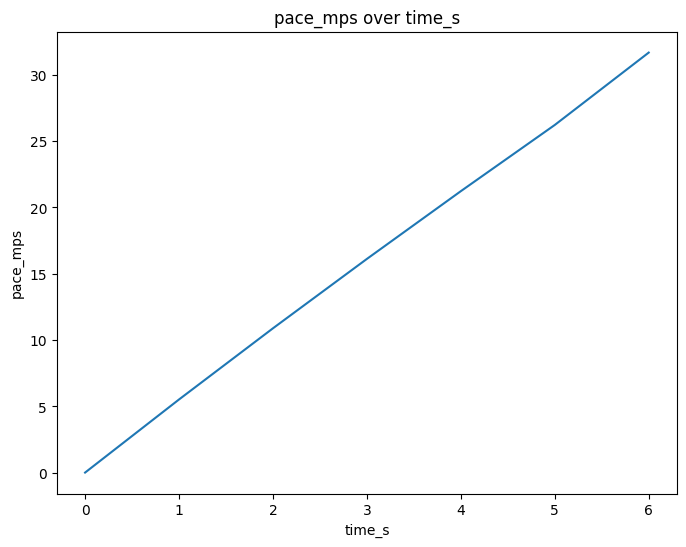

In [4]:
import matplotlib.pyplot as plt
# Plot pace over time
# x_label = 'distance_m'
x_label = 'time_s'
y_label = 'pace_mps'
plt.figure(figsize=(8, 6))
plt.plot(data[x_label], data[y_label])
plt.title(f'{y_label} over {x_label}')
plt.xlabel(f'{x_label}')
plt.ylabel(f'{y_label}')
plt.show()


In [29]:
import pprint
pprint.pprint(data["pace_efficiency"])

[1.0,
 0.10000967011253424,
 0.010004121924166708,
 0.001000959506362719,
 0.00010017365516871239,
 1.0027352496182732e-05,
 1.0039359454946972e-06,
 1.0053011563978877e-07,
 1.006783022254369e-08,
 1.0083233031920016e-09,
 1.0098526178539795e-10,
 1.0112903099382623e-11,
 1.0125445290423699e-12,
 1.0135117683960801e-13,
 1.0140764329007076e-14,
 1.0141105349518826e-15,
 1.0134735362062329e-16,
 1.0120123392743917e-17,
 1.009561540153091e-18,
 1.0059440172233442e-19,
 1.0009719369906158e-20,
 9.944463686776291e-22,
 9.861635840340212e-23,
 9.75917679409203e-24,
 9.635046628411265e-25,
 9.487274054672896e-26,
 9.314011080399636e-27,
 9.11360020316413e-28,
 8.884649622218819e-29,
 8.626114846861522e-30,
 8.337384432779994e-31,
 8.018366392658028e-32,
 7.66957205821803e-33,
 7.292192309864629e-34,
 6.888160344003386e-35,
 6.460194481002321e-36,
 6.011814136754137e-37,
 5.547322315908215e-38,
 5.071748774413789e-39,
 4.590749554109549e-40,
 4.110460989484679e-41,
 3.637310620033976e-42,
 3